In [1]:
import os
import sys
import numpy as np
import pandas as pd
import nibabel as nib
from subprocess import check_call
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

#ts = sys.argv[1]
#ratings = pd.read_csv(sys.argv[2], index_col=0)
#duration = sys.argv[3]
#working_dir = os.path.dirname(ts)
#os.chdir(working_dir)
sub_data_dir = '/Users/catcamacho/Box/CCP/HBN_study/proc/first_level/'
sub_files = glob( sub_data_dir + '/*task-movie*.nii')
ratings_dir = '/Users/catcamacho/Box/CCP/HBN_study/HBN_video_coding/processing/summary/'
movieDM_ratings = pd.read_csv(ratings_dir + '/DM_summary_codes.csv', index_col=0)
movieTP_ratings = pd.read_csv(ratings_dir + '/TP_summary_codes.csv', index_col=0)

TR = 0.8
movieTP_duration = 200 # in seconds
movieDM_duration = 600 # in seconds

In [19]:
def hrf(TR, duration, time_to_peak=6, undershoot_length=12):
    from scipy.stats import gamma
    
    time = np.arange(0, duration, TR)
    peak = gamma.pdf(time, time_to_peak)
    undershoot = gamma.pdf(time, undershoot_length)
    hrf_vals = peak-0.35*undershoot
    return(hrf_vals)

def convolve_regressors(regressors, hrf_tr, cols_to_keep, outfile='regressors.csv'):
    regress_matrix = pd.DataFrame()
    for c in cols_to_keep:
        regress_matrix[c] = np.convolve(regressors[c], hrf_tr)[:len(regressors)]
    
    regress_matrix['mean'] = 1 
    
    regress_matrix.to_csv(outfile)
    designmat = os.path.abspath(outfile)
    return(regress_matrix, designmat)

def massuni_linregress(ciftiseries_file, designmat, out_prefix):
    from sklearn.preprocessing import StandardScaler
    designmat_df = designmat
    ss = StandardScaler()
    designmat = ss.fit_transform(designmat.to_numpy())
    neuro_img = nib.load(ciftiseries_file)
    neuro_data = neuro_img.get_fdata()
    neuro_data = ss.fit_transform(neuro_data)
    beta_data = np.zeros((designmat.shape[1],neuro_data.shape[1]))
    for a in range(0,neuro_data.shape[1]):
        Y = neuro_data[:,a]
        X = np.linalg.pinv(designmat)
        beta_data[:,a] = np.dot(X, Y)

    bm = neuro_img.header.get_axis(1)
    sc = nib.cifti2.cifti2_axes.ScalarAxis(name=['beta'])
    for i, reg in enumerate(designmat_df.columns):
        temp_img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(beta_data[i,:], axis=0),(sc, bm))
        nib.save(temp_img, out_prefix+'{0}.pscalar.nii'.format(reg))

In [20]:
cols_to_keep1 = ['pos_imca', 'neg_imca', 'rms', 'brightness']
cols_to_keep2 = ['pos_iaca', 'neg_iaca', 'global_intensity', 'rms', 'brightness']

hrf_tr = hrf(TR, movieDM_duration)
TP_convolved, TP_designmat = convolve_regressors(movieDM_ratings, hrf_tr, 
                                                 cols_to_keep2, outfile='temp.csv')
#out_prefix = ciftiseries_file[2:31]
#massuni_linregress(ciftiseries_file, TP_convolved, out_prefix)

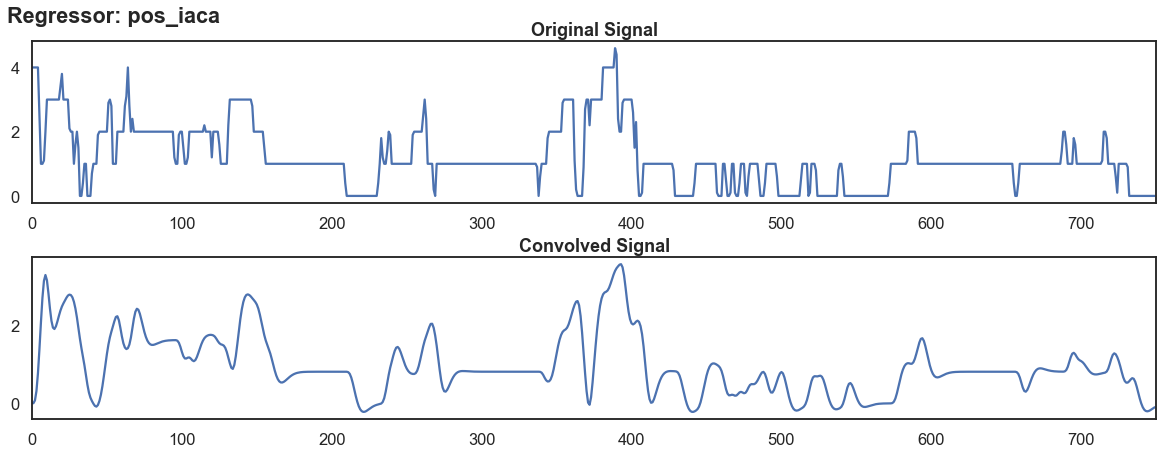

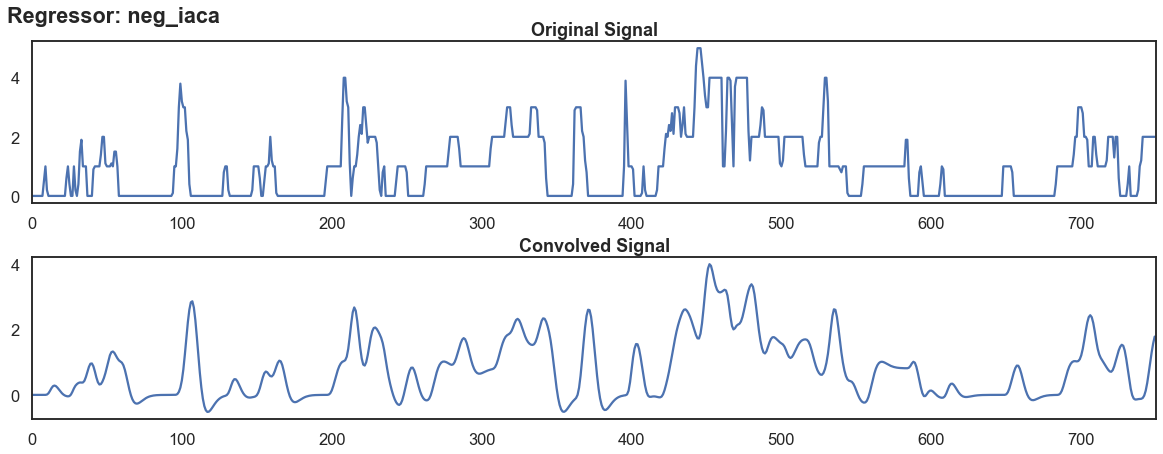

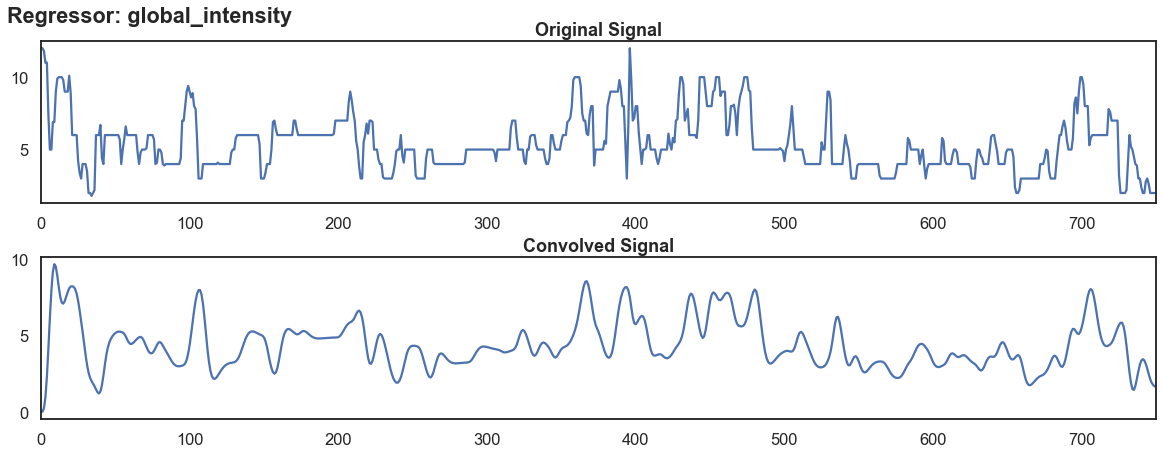

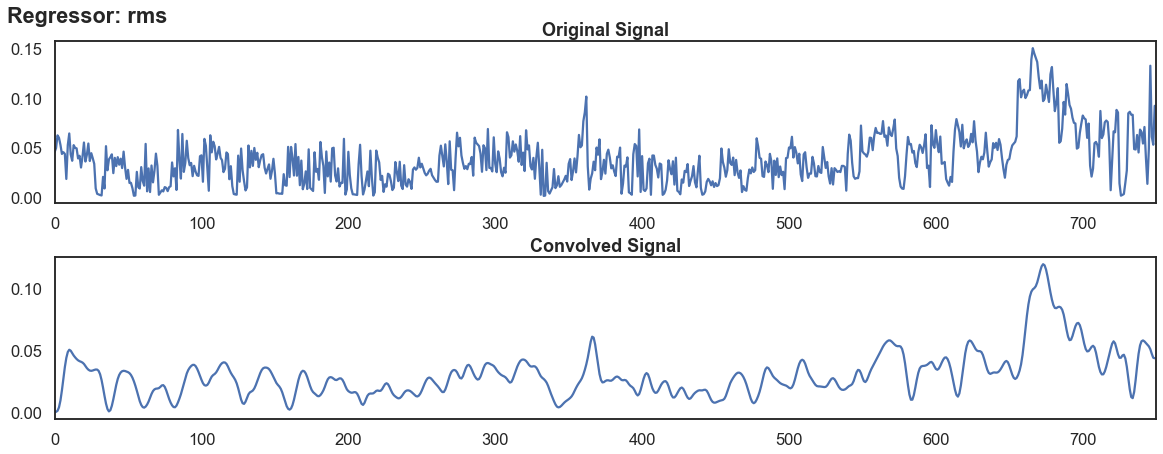

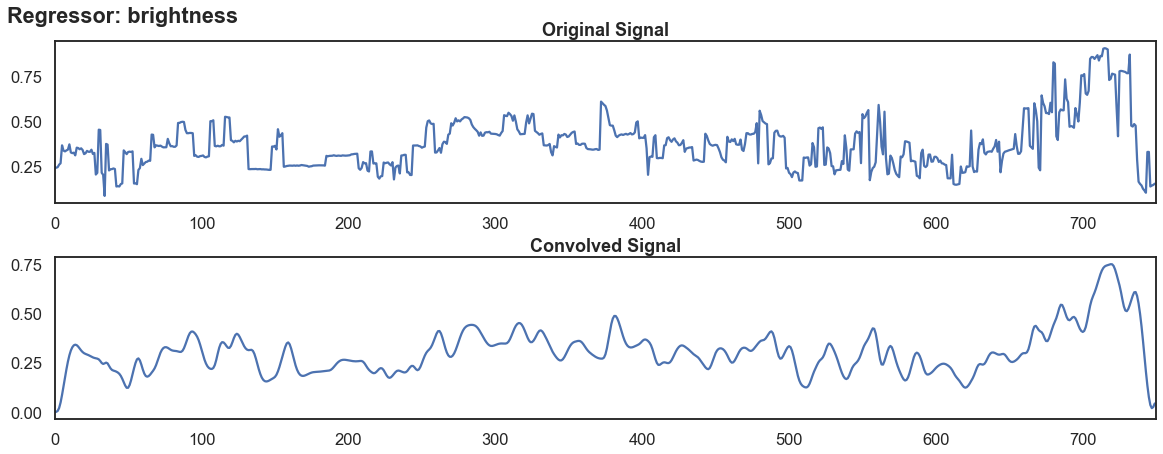

In [22]:
sns.set(context='talk', style='white')

for c in cols_to_keep2:
    fig, ax = plt.subplots(2,1,figsize=(16,6), constrained_layout=True)
    fig.suptitle('Regressor: '+c, ha='left', va = 'bottom', x=0, weight='bold')
    plt.setp(ax,xlim=(0,750))
    ax[0].plot(movieDM_ratings[c])
    ax[0].set_title('Original Signal', weight='bold')
    ax[1].plot(TP_convolved[c])
    ax[1].set_title('Convolved Signal', weight='bold')
    plt.show()
    plt.close()

In [7]:
cols_to_keep1 = ['pos_imca', 'neg_imca', 'rms', 'brightness']
cols_to_keep2 = ['pos_iaca', 'neg_iaca', 'global_intensity', 'rms', 'brightness']
movieDM_setA = pd.read_csv('movieDM_regressors_setA.csv', index_col=0)
movieDM_setB = pd.read_csv('movieDM_regressors_setB.csv', index_col=0)

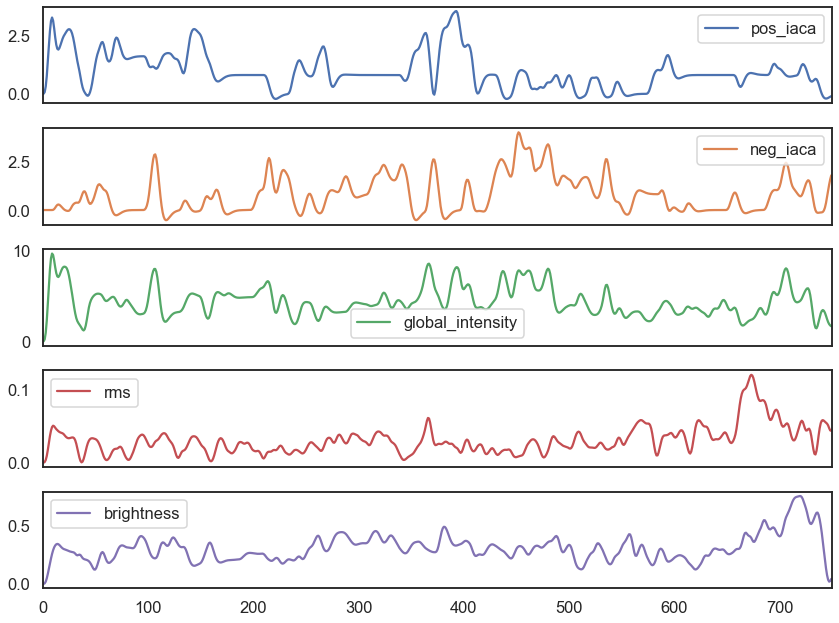

In [17]:
sns.set(context='talk', style='white')
movieDM_setB[movieDM_setB.columns[:-1]].plot(subplots=True, figsize=(12,9), xlim=(0,750))
plt.tight_layout()
plt.savefig('movieDM_setB.svg')

In [82]:
from numpy.linalg import pinv
ciftiseries_file = './sub-NDARFM211KDJ_task-movieTP_bold1_AP_Atlas_rescale_resid0.9_filt_gordon.32k_fs_LR.ptseries.nii'
prefix = 'movieTP_beta_'
neuro_img = nib.load(ciftiseries_file)
neuro_data = neuro_img.get_fdata()
beta_data = np.zeros((TP_convolved.shape[1],neuro_data.shape[1]))
for a in range(0,neuro_data.shape[1]):
    Y = neuro_data[:,a]
    X = np.linalg.pinv(TP_convolved.to_numpy())
    beta_data[:,a] = np.dot(X, Y)
    
bm = neuro_img.header.get_axis(1)
sc = nib.cifti2.cifti2_axes.ScalarAxis(name=['beta'])
for i, reg in enumerate(TP_convolved.columns):
    temp_img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(beta_data[i,:], axis=0),(sc, bm))
    nib.save(temp_img, prefix+'{0}.pscalar.nii'.format(reg))

In [90]:
ciftiseries_file[:29]

'./sub-NDARFM211KDJ_task-movie'

In [81]:
np.expand_dims(beta_data[i,:], axis=0).shape

(1, 333)

In [78]:
ax = neuro_img.header.get_axis(1)
ax.name

array(['L_None_1', 'L_None_2', 'L_None_3', 'L_None_4', 'L_None_5',
       'L_None_6', 'L_None_7', 'L_None_8', 'L_None_9', 'L_None_10',
       'L_None_11', 'L_None_12', 'L_None_13', 'L_None_14', 'L_None_15',
       'L_None_16', 'L_None_17', 'L_None_18', 'L_None_19', 'L_None_20',
       'L_None_21', 'R_None_22', 'R_None_23', 'R_None_24', 'R_None_25',
       'R_None_26', 'R_None_27', 'R_None_28', 'R_None_29', 'R_None_30',
       'R_None_31', 'R_None_32', 'R_None_33', 'R_None_34', 'R_None_35',
       'R_None_36', 'R_None_37', 'R_None_38', 'R_None_39', 'R_None_40',
       'R_None_41', 'R_None_42', 'R_None_43', 'R_None_44', 'R_None_45',
       'R_None_46', 'R_None_47', 'L_Default_1', 'L_Default_2',
       'L_Default_3', 'L_Default_4', 'L_Default_5', 'L_Default_6',
       'L_Default_7', 'L_Default_8', 'L_Default_9', 'L_Default_10',
       'L_Default_11', 'L_Default_12', 'L_Default_13', 'L_Default_14',
       'L_Default_15', 'L_Default_16', 'L_Default_17', 'L_Default_18',
       'L_Default_19'